In [1]:
from __future__ import division
%matplotlib nbagg
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from python_latexify import latexify, format_axes
latexify()

import matplotlib
matplotlib.rcParams.update(latexify())
import matplotlib.pyplot as plt

#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 14}
#matplotlib.rc('font', **font)


In [23]:
from censorship_ratios import *

DATA = "data/"
PLOTS = "results/final_figures-20150429/plots-0.12/"
TABLES = "results/final_figures-20150429/tables-0.12/"
if not os.path.exists(PLOTS):
    os.makedirs(PLOTS)
if not os.path.exists(TABLES):
    os.makedirs(TABLES)

## sIP_subcat original

In [24]:
df_sIP_subcat_orig = pd.read_csv(DATA + "Servers_IMC.txt.original")
df_sIP_subcat_orig.to_csv("utils/Servers_IMC-original.txt")
df_sIP_subcat_orig['subcat'] = df_sIP_subcat_orig['subcat'].apply(
    lambda x: x.replace('kids_and_teens', 'teens'))

## SANITY CHECK MEASUREMENTS: APR 12 DATA

In [45]:
df_mock = pd.read_pickle(DATA + "case_detected_all_20150412.pkl")
print len(df_mock)

235695


In [26]:
meas = df_mock.groupby('sIP')['port'].count()
bad_sIP = list( meas[meas <= 1].index )
print bad_sIP
meas[meas > 1].describe()

['54.255.183.119']


count    473.000000
mean     498.295983
std      121.193260
min      289.000000
25%      405.000000
50%      472.000000
75%      592.000000
max      838.000000
Name: port, dtype: float64

In [27]:
df_sanitized = df_mock[~df_mock.sIP.isin(bad_sIP)]
len(df_sanitized)

235694

# CALIBRATION

In [28]:
censorship = get_censorship_by_country_sIP(df_sanitized)['global']

In [29]:
len(censorship)

473

In [30]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i for i in range(len(xdata))]
    return xdata, ydata

<IPython.core.display.Javascript object>


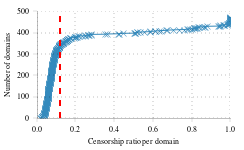

In [31]:
THRESH = 0.12
x, y = getCDF( list( censorship ) )
fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "calibrating_sIPs_knee")
fig1.savefig(PLOTS + "calibrating_sIPs_knee.pdf")

### Greater than 12% censorship at the knee

In [32]:
THRESH = 0.12

In [33]:
bad_sIP = list(censorship[censorship > THRESH].reset_index()['sIP'])
good_sIP = list(censorship[censorship <= THRESH].reset_index()['sIP'])

In [34]:
df_sanitized2 = df_sanitized[df_sanitized['sIP'].isin(good_sIP)]
print len(bad_sIP), len(good_sIP), len(df_sanitized2), len(df_sanitized2['sIP'].unique())

127 346 167864 346


### ONLY KEEP good_sIPs and ADD torDir NOW

In [35]:
df_sIP_subcat_calibrated = df_sIP_subcat_orig[(df_sIP_subcat_orig['sIP'].isin(good_sIP)) 
                                              | (df_sIP_subcat_orig['domain'].isin(['torDir'])) ]
print "TOTAL DOMAINS IN TEST LIST AFTER CALIBRATION = ", len(df_sIP_subcat_calibrated)

TOTAL DOMAINS IN TEST LIST AFTER CALIBRATION =  352


# SAVE UPDATED SUBCATS

In [36]:
subcat_duplicated = defaultdict(list)
for ix, row in df_sIP_subcat_calibrated.iterrows():
    if len(row[2].split("|"))>1:
        shared = 1
    else:
        shared = 0
    for subcat in row[2].split("|"):
        if subcat == 'kids_and_teens':
            subcat = 'teens'
        subcat_duplicated['sIP'].append(row[0])
        subcat_duplicated['domain'].append(row[1])
        subcat_duplicated['subcat'].append(subcat)
        subcat_duplicated['shared'].append(shared)
df_sIP_subcat_disjoint = pd.DataFrame(subcat_duplicated)
#df_sIP_subcat_disjoint.to_csv("utils/Servers_IMC-disjoint.txt")

In [37]:
#df_sIP_subcat_calibrated.to_csv("utils/Servers_IMC-calibrated.txt")

good_sIP = list(df_sIP_subcat_calibrated['sIP'])

# COMPARED WITH MAIN DATA

In [17]:
df_all1 = pd.read_pickle(DATA + "case_detected_all_20150423.pkl")
df_all2 = pd.read_pickle(DATA + "case_detected_all_20150427.pkl")
df_all = pd.concat([df_all1,df_all2])
print len(df_all1), len(df_all2), len(df_all)

250593 146328 396921


In [18]:
del df_all1, df_all2
#del df_mock

In [38]:
df_final = df_all[df_all['sIP'].isin(list(df_sIP_subcat_calibrated['sIP']))]
print len(df_final)

275016


# See the affect of calibration

<IPython.core.display.Javascript object>


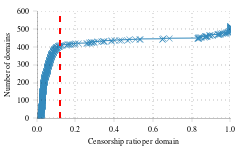

In [39]:
censorship = get_censorship_by_country_sIP(df_all)['global']
THRESH = 0.12

x, y = getCDF( list( censorship ) )
fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "before_calibrating_full_data")
#fig1.savefig(PLOTS + "calibrating_sIPs_knee.pdf")

<IPython.core.display.Javascript object>


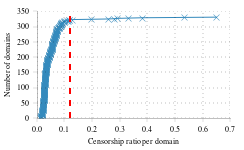

In [40]:
censorship = get_censorship_by_country_sIP(df_final)['global']
THRESH = 0.12

x, y = getCDF( list( censorship ) )
fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "after_calibrating_full_data")
#fig1.savefig(PLOTS + "calibrating_sIPs_knee.pdf")

In [42]:
censorship = get_censorship_by_country_sIP(df_final)['global']
THRESH = 0.12

### WHAT ESCAPES?

In [44]:
pd.DataFrame(censorship[censorship > THRESH ]).reset_index().merge(df_sIP_subcat_calibrated, on='sIP')

,sIP,global,domain,subcat
0,158.106.84.60,0.330590,squirt.org,adult
1,193.23.244.244,0.126225,torDir,circum
2,194.109.206.212,0.257683,torDir,circum
3,52.74.69.52,0.290722,zomato.com,recreation|regional
4,54.163.241.169,0.530667,www.edx.org,reference
5,54.164.68.43,0.381551,popsci.com,teens|science
6,54.174.118.57,0.195149,sciencedaily.com,teens|science
7,54.174.139.140,0.281106,wired.com,arts|computers
8,54.225.210.86,0.648980,dorkly.com,games


# EXPLAINING SERVER SIDE TRASHES

In [81]:
df_server_side = df_mock[~df_mock['sIP'].isin(good_sIP)]

In [82]:
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)
server_blocked = get_ratios(df_description)

In [83]:
print "BAD sIPs trashed = ", len(server_blocked)

BAD sIPs trashed =  127


In [110]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

In [120]:
def plot_case_CDF(df, fig1, ax1, dimension='case2'):
    """
    df must contain 3 columns: case1, case2, case3
    df can be indexed by domains, sIP, categs, countries, regions
    """
    x, y = getCDF( list( df[dimension] ) )
    ax1.plot(x, y, color='r', ls='--')
    ax1.grid(1)
    fig1.tight_layout()
    format_axes(ax1)
    return

In [135]:
def plot_scatter_cases(df, fig1, ax1):
    """
    df must contain 3 columns: case1, case2, case3
    df can be indexed by domains, sIP, categs, countries, regions
    """
    x = df['case1']
    y = df['case3']
    z = 1-df['case2']

    ax1.scatter(x, y, s=100*z, marker='o', facecolors='none', edgecolors='k')
    ax1.grid(1)
    fig1.tight_layout()
    format_axes(ax1)
    
    return

#fig1.savefig(PLOTS + "calibrating_sIPs_knee")
#fig1.savefig(PLOTS + "calibrating_sIPs_knee.pdf")

<IPython.core.display.Javascript object>


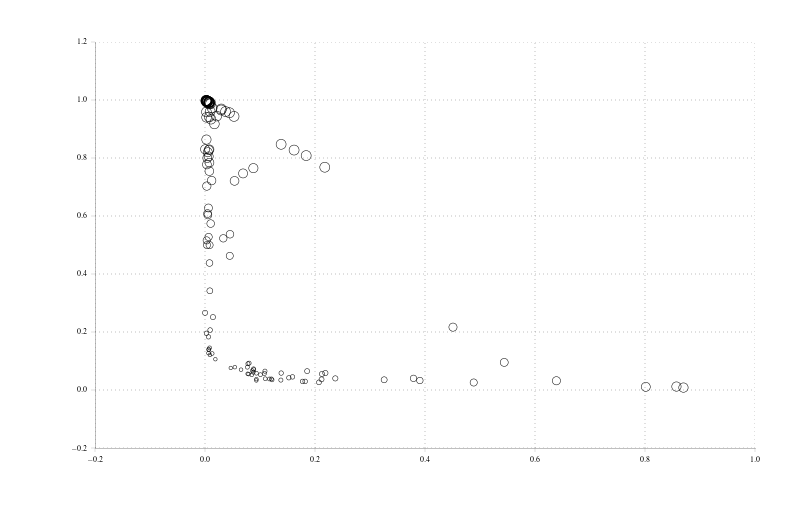

In [136]:
fig1, ax1 = plt.subplots(1,1)
#plot_case_CDF(server_blocked, fig1, ax1, 'case2')
plot_scatter_cases(server_blocked, fig1, ax1)
fig1.show()

In [134]:
server_blocked

,case,0,1,2,3,4,tot,err,case1,case2,case3
sIP,domain,,,,,,,,,,
103.6.182.20,agoda.com,63,159,547,42,7,748,70,0.212567,0.731283,0.056150
104.16.5.13,change.org,32,5,4,615,51,624,83,0.008013,0.006410,0.985577
104.16.7.118,petmd.com,44,1,0,589,45,590,89,0.001695,0.000000,0.998305
104.20.12.28,studentdoctor.net,25,2,0,576,40,578,65,0.003460,0.000000,0.996540
104.20.28.30,bungie.net,43,2,1,547,42,550,85,0.003636,0.001818,0.994545
104.20.28.34,tunnelbear.com,27,2,3,628,55,633,82,0.003160,0.004739,0.992101
104.20.5.196,furaffinity.net,15,2,0,438,35,440,50,0.004545,0.000000,0.995455
104.28.7.85,indiansexstories.net,46,4,1,560,47,565,93,0.007080,0.001770,0.991150
107.20.154.40,strava.com,33,253,130,13,9,396,42,0.638889,0.328283,0.032828


In [ ]:
df_client_side = df_mock[df_mock['sIP'].isin(good_sIP)]
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)
server_blocked = get_ratios(df_description)
plot_scatter_cases(server_blocked, 0).show()